# Let's see if it's working

In [1]:
import torch
from torch import empty

import matplotlib.pyplot as plt

from nn.sequential import *
from nn.activation import *
from nn.linear import *
from nn.loss import *
from trainer import Trainer

In [2]:
def gen_data(n):
    x = empty((2 * n, 2)).uniform_(0, to=1)
    pi = empty((1)).fill_(0).acos().item() * 2

    target = ((x - empty(1,2).fill_(0.5)).pow(2).sum(dim=1) <= 1/(2*pi)) * 1

    x_train, x_test = x[:n], x[n:]
    y_train, y_test = target[:n], target[n:]
    return x_train, x_test, y_train.view(-1, 1), y_test.view(-1, 1)

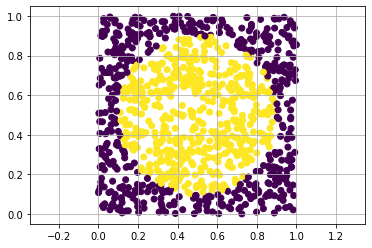

In [3]:
# Create test data
x_train, x_test, y_train, y_test = gen_data(1000)

# Plot test data
plt.scatter(x_train.numpy()[:,0], x_train.numpy()[:,1], c=y_train[:, 0])
plt.axis('equal')
plt.grid()
plt.show()

In [4]:
LinNet_ours = Sequential((
    Linear(2, 25),
    ReLU(),
    Linear(25, 25),
    ReLU(),
    Linear(25, 25),
    ReLU(),
    Linear(25, 1)),
    MSELoss()
)

LinNet_theirs = torch.nn.Sequential(
    torch.nn.Linear(2, 25),
    torch.nn.ReLU(),
    torch.nn.Linear(25, 25),
    torch.nn.ReLU(),
    torch.nn.Linear(25, 25),
    torch.nn.ReLU(),
    torch.nn.Linear(25, 1)
)
print(f'ours {LinNet_ours}, theirs {LinNet_theirs}')

print(Linear(25, 25))

ours Sequential(
	(0): Linear(in_features=2, out_features=25, bias=True)
	(1): ReLU()
	(2): Linear(in_features=25, out_features=25, bias=True)
	(3): ReLU()
	(4): Linear(in_features=25, out_features=25, bias=True)
	(5): ReLU()
	(6): Linear(in_features=25, out_features=1, bias=True)
), theirs Sequential(
  (0): Linear(in_features=2, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=25, bias=True)
  (5): ReLU()
  (6): Linear(in_features=25, out_features=1, bias=True)
)
Linear(in_features=25, out_features=25, bias=True)


In [5]:
t = Trainer(nb_epochs=321)
_ = t.fit(LinNet_ours, x_train, y_train, x_test, y_test, batch_size=32)

# Epoch   1/321:	 loss=4.8000e-01	 loss_val=2.5000e-01
# Epoch  33/321:	 loss=2.5000e-01	 loss_val=2.4000e-01
# Epoch  65/321:	 loss=2.4000e-01	 loss_val=2.4000e-01
# Epoch  97/321:	 loss=2.2000e-01	 loss_val=2.2000e-01
# Epoch 129/321:	 loss=1.8000e-01	 loss_val=1.8000e-01
# Epoch 161/321:	 loss=1.1000e-01	 loss_val=1.1000e-01
# Epoch 193/321:	 loss=8.0000e-02	 loss_val=8.0000e-02
# Epoch 225/321:	 loss=7.0000e-02	 loss_val=7.0000e-02
# Epoch 257/321:	 loss=6.0000e-02	 loss_val=6.0000e-02
# Epoch 289/321:	 loss=6.0000e-02	 loss_val=6.0000e-02
# Epoch 321/321:	 loss=6.0000e-02	 loss_val=6.0000e-02


In [9]:
# Calculate error rate
y_test_pred = LinNet_ours(x_test).round()
test_error = (y_test_pred != y_test).sum() / 1000 * 100

print(f"Test error rate: {test_error}%")

Test error rate: 4.400000095367432%


In [7]:
# Iterate over samples in x
loss_fn_theirs = torch.nn.MSELoss()
optimizer_theirs = torch.optim.SGD(LinNet_theirs.parameters(), lr=0.01)
train_loss_ours = []
train_loss_theirs = []
n_epochs = 150
batch_size = 32
for e in range(n_epochs):
    for i in range(0, len(x_train), batch_size):
        # Get one data sample
        x_sample = x_train[i:i+batch_size]
        y_sample = y_train[i:i+batch_size].float()

        # Forward ours
        out_ours = LinNet_ours(x_sample)
        loss_ours = LinNet_ours.loss(out_ours, y_sample)
        train_loss_ours.append(loss_ours)
        #print(f'our ours: {out}')

        # Forward theirs
        out_theirs = LinNet_theirs(x_sample)
        loss_theirs = loss_fn_theirs(out_theirs, y_sample)
        train_loss_theirs.append(loss_theirs.item())
        #print(f'our theirs: {out}')

        # Backward ours
        LinNet_ours.backward()

        # Backward theirs
        optimizer_theirs.zero_grad()
        loss_theirs.backward()
        optimizer_theirs.step()

        # Update params
        LinNet_ours.update_params(optim='sgd', lr=0.01)
    print(f'finished epoch {e} with train loss: {sum(train_loss_ours)/len(train_loss_ours)} (ours), {sum(train_loss_theirs)/len(train_loss_theirs)} (theirs)')

finished epoch 0 with train loss: 0.05819800868630409 (ours), 0.3451404934749007 (theirs)
finished epoch 1 with train loss: 0.0581594742834568 (ours), 0.3026771729346365 (theirs)
finished epoch 2 with train loss: 0.058122944086790085 (ours), 0.2854218262558182 (theirs)
finished epoch 3 with train loss: 0.058089468628168106 (ours), 0.2765323151834309 (theirs)
finished epoch 4 with train loss: 0.058055389672517776 (ours), 0.2711217971518636 (theirs)
finished epoch 5 with train loss: 0.05802400782704353 (ours), 0.2674586447731902 (theirs)
finished epoch 6 with train loss: 0.05798724666237831 (ours), 0.26479567480938776 (theirs)
finished epoch 7 with train loss: 0.05795431137084961 (ours), 0.2627594492514618 (theirs)
finished epoch 8 with train loss: 0.05792129039764404 (ours), 0.26114326948300004 (theirs)
finished epoch 9 with train loss: 0.0578896626830101 (ours), 0.25982286566868423 (theirs)
finished epoch 10 with train loss: 0.057858195155858994 (ours), 0.2587196135639467 (theirs)
fini